In [550]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

input_annotation_file = 'data/t1_mris/csa_population_cbtn.csv'
df_preds = pd.read_csv(input_annotation_file, header=0)

In [551]:
# add at risk numbers
# log rank test 
# remove years into days

In [552]:
csv_survival = 'data/csv_files/cbtn-all-LGG-BRAF.csv'
df_survival = pd.read_csv(csv_survival, header=0)
df_survival = df_survival[df_survival['Diagnosis Type']=='Initial CNS Tumor']
df_survival.columns

Index(['Subject_ID', 'BRAF-Status', 'Assay Type',
       'Flywheel (1s are on Flywheel)', 'CBTN Subject ID',
       'CBTN Specimen Group ID', 'Associated Germline Collection',
       'Research T/N WGS', 'Research Tumor RNAseq', 'Clin Seq for Event',
       'Clin Seq Other', 'CBTN Molecular Subtype', 'Gender', 'Ethnicity',
       'Multiple Races', 'Race', 'Diagnosis Type', 'Age at Diagnosis',
       'Clinical Status', 'Multiple Diagnoses', 'Diagnosis',
       'Other Diagnosis Description', 'Multiple Tumor Locations',
       'Tumor Location', 'Multiple Other Medical Conditions',
       'Medical Condition', 'Multiple Cancer Predispositions',
       'Cancer Predispositions', 'Last Known Clinical Status',
       'Age at Last Known Clinical Status', 'Treatment Changed', 'Treatment',
       'Surgery', 'Extent of Tumor Resection', 'Sample Origin', 'Chemotherapy',
       'Chemotherapy Type', 'Protocol Number and Treatment Arm',
       'Age at Chemotherapy Start', 'Age at Chemotherapy Stop',
   

In [576]:
df_preds['Gender']

0      1
1      2
2      2
3      2
4      1
      ..
117    2
118    2
119    2
120    1
121    1
Name: Gender, Length: 122, dtype: int64

In [554]:
# get norm TMT for the X age range - would be good to have it from gamlss

input_annotation_file = 'data/pop_norms.csv'
df_norm = pd.read_csv(input_annotation_file, header=0)

df_norm=df_norm[df_norm["TMT PRED AVG"]<20]

In [593]:
i = 0
survival_lst = []
for i in range(0,df_preds.shape[0]):
    row = df_preds.iloc[i]
    df_norm_aged = df_norm[(df_norm['Age']==row['Age']) & (df_norm['Gender']==row['Gender'])]
    
    five_q = round(df_norm_aged['TMT PRED AVG'].quantile([.10])[0.10],2)
    #first_q = round(df_norm_aged['TMT PRED AVG'].quantile([.25])[0.25],2)
    #mean_q = round(df_norm_aged['TMT PRED AVG'].quantile([.5])[0.5],2)
    #third_q = round(df_norm_aged['TMT PRED AVG'].quantile([.75])[0.75],2)
    ninetyfive_q = round(df_norm_aged['TMT PRED AVG'].quantile([.90])[0.90],2)
    
    print("TMT AVG",df_preds['TMT PRED AVG'][i])
    if df_preds['TMT PRED AVG'][i] != 0 and \
    df_survival[df_survival['CBTN Subject ID']==row['ID'].split("_")[0]]['Overall Survival'].values[0]!="Not Reported" and \
    df_survival[df_survival['CBTN Subject ID']==row['ID'].split("_")[0]]['Progression Free Survival'].values[0]!="Not Reported":
        
        #print("wrt to norm, patient is in qualtile:")
        quantile1,quantile2,quantile3 = 0,0,0
        quantile = 0
        if df_preds['TMT PRED AVG'][i]<five_q:
            quantile1 = 1#"<10%"
            quantile = 0
        elif five_q<df_preds['TMT PRED AVG'][i]<ninetyfive_q:
            quantile2 = 1#"<10-90%"
            quantile = 1
        elif ninetyfive_q<df_preds['TMT PRED AVG'][i]:
            quantile3 = 1#">90%"
            quantile = 2
        print("Quantiles for age",df_preds['Age'][i],":",first_q,mean_q,third_q)

        #print(row['ID'].split("_")[0],df_survival[df_survival['CBTN Subject ID']==row['ID'].split("_")[0]]['Overall Survival'].values[0])
        survival_overall = float(df_survival[df_survival['CBTN Subject ID']==row['ID'].split("_")[0]]['Overall Survival'].values[0])
        duration = survival_prog = float(df_survival[df_survival['CBTN Subject ID']==row['ID'].split("_")[0]]['Progression Free Survival'].values[0])
        
        #if duration >= 5:
        #    duration = 5
        #else:
        #    duration = int(duration)
            
        resection = df_survival[df_survival['CBTN Subject ID']==row['ID'].split("_")[0]]['Extent of Tumor Resection'].values[0]
        resection_bio,resection_total,resection_part=0,0,0
        if resection=="Gross/Near total resection":
            resection_total=1
            
        radiation = df_survival[df_survival['CBTN Subject ID']==row['ID'].split("_")[0]]['Radiation'].values[0]
        radiation_y,radiation_n=0,0
        if radiation == "Yes":
            radiation_y = 1
        
        chemo = df_survival[df_survival['CBTN Subject ID']==row['ID'].split("_")[0]]['Chemotherapy'].values[0]
        chemo_y, chemo_n=0,0
        if chemo == "Yes":
            chemo_y = 1
          
        female,male=0,0
        if df_preds['Gender'][i] ==2:
            female=1
        #resection = Extent of Tumor Resection Radiation Chemotherapy
        if survival_overall != 'Not Reported' and duration != 'Not Reported':
            
            event=0
            status = df_survival[df_survival['CBTN Subject ID']==row['ID'].split("_")[0]]['Last Known Clinical Status'].values[0]
        
            if survival_overall>survival_prog and "Alive" in status:
                event = 1 # and "Deceased" in df_survival['Last Known Clinical Status'][i].lower()
            
            survival_lst.append([df_preds['ID'][i],df_preds['Age'][i],
                                 female, \
                                 #df_preds['TMT PRED AVG'][i],
                                 quantile,
                                 resection_total,
                                 radiation_y,
                                 chemo_y,
                                 duration,
                                 event])


TMT AVG 5.67
Quantiles for age 6 : 9.35 10.52 11.95
TMT AVG 10.535
Quantiles for age 9 : 9.35 10.52 11.95
TMT AVG 0.0
TMT AVG 0.0
TMT AVG 0.0
TMT AVG 9.4
Quantiles for age 6 : 9.35 10.52 11.95
TMT AVG 6.5600000000000005
Quantiles for age 6 : 9.35 10.52 11.95
TMT AVG 17.65
TMT AVG 9.08
Quantiles for age 17 : 9.35 10.52 11.95
TMT AVG 12.755
Quantiles for age 12 : 9.35 10.52 11.95
TMT AVG 12.755
Quantiles for age 12 : 9.35 10.52 11.95
TMT AVG 13.405
Quantiles for age 11 : 9.35 10.52 11.95
TMT AVG 8.53
Quantiles for age 9 : 9.35 10.52 11.95
TMT AVG 5.945
Quantiles for age 5 : 9.35 10.52 11.95
TMT AVG 2.54
TMT AVG 16.815
Quantiles for age 14 : 9.35 10.52 11.95
TMT AVG 16.815
Quantiles for age 14 : 9.35 10.52 11.95
TMT AVG 6.664999999999999
Quantiles for age 12 : 9.35 10.52 11.95
TMT AVG 1.13
Quantiles for age 4 : 9.35 10.52 11.95
TMT AVG 8.815000000000001
Quantiles for age 6 : 9.35 10.52 11.95
TMT AVG 0.0
TMT AVG 9.985
Quantiles for age 4 : 9.35 10.52 11.95
TMT AVG 8.37
Quantiles for age 8 

In [603]:
df_surv = pd.DataFrame(survival_lst,columns=['id','Age','Female',#'TMT PRED AVG',
                                             "Quantile",
                                             "Resection_total",
                                             "Radiation_yes",
                                             "Chemo_yes",
                                             "Duration","Event"])


In [595]:
df_surv

,id,Age,Female,Quantile<10,Resection_total,Radiation_yes,Chemo_yes,Duration,Event
0,C1003557_1_T1W,6,0,0,0,0,1,520.0,0
1,C1003680_1_T1W,9,1,1,0,0,1,512.0,0
2,C1042056_1_T1W,6,0,1,0,0,0,86.0,1
3,C1046730_1_T1W,6,0,0,0,0,1,463.0,1
4,C1060998_1_T1W,17,0,0,1,0,0,90.0,0
...,...,...,...,...,...,...,...,...,...
101,C949683_1_T1W,14,1,1,1,0,0,766.0,0
102,C953127_1_T1W,10,1,0,1,0,1,1104.0,1
103,C972684_1_T1W,8,1,1,1,0,0,374.0,0
104,C974898_1_T1W,11,0,2,1,1,1,1066.0,1


In [596]:
from lifelines import CoxPHFitter

In [605]:
df_surv["Age"].min(),df_surv["Age"].max(),df_surv["Age"].mean()

(4, 20, 10.264150943396226)

In [606]:
df_surv = df_surv.drop(['id'], axis=1)

In [607]:
cph = CoxPHFitter()
cph.fit(df_surv, duration_col='Duration', event_col='Event')
cph.print_summary()  # access the individual results using cph.summary

# check if the vars are cat or continious
# remove TMT PRED AVG or quantile?

<lifelines.CoxPHFitter: fitted with 106 total observations, 64 right-censored observations>
             duration col = 'Duration'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 106
number of events observed = 42
   partial log-likelihood = -145.50
         time fit was run = 2022-12-20 21:28:14 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
Age               0.10       1.10       0.05             0.01             0.19                 1.01                 1.21
Female           -0.19       0.83       0.33            -0.85             0.46                 0.43                 1.59
Quantile         -0.25       0.78       0.27            -0.77             0.27                 0.46                 1.31
Resection_total  -1.11       0.33       0.48            -2.06            -0.17                 0.13                 0.84
Radiation_yes    -0.47       0.63       0.79            -2.02             1.08                 0.13                 2.96
Chemo_yes         0.33       1.39       0.35            -0.36             1.02                 0.70                 2.77

                  cmp to     z    p   -log2(p)
covariate                                     
Age                 0.00  2.16 0.03       5.01
Female              0.00 -0.57 0.57       0.82
Quantile            0.00 -0.95 0.34       1.54
Resection_total     0.00 -2.32 0.02       5.63
Radiation_yes       0.00 -0.59 0.55       0.85
Chemo_yes           0.00  0.94 0.35       1.53
---
Concordance = 0.70
Partial AIC = 303.00
log-likelihood ratio test = 15.69 on 6 df
-log2(p) of ll-ratio test = 6.01

<AxesSubplot: xlabel='log(HR) (95% CI)'>

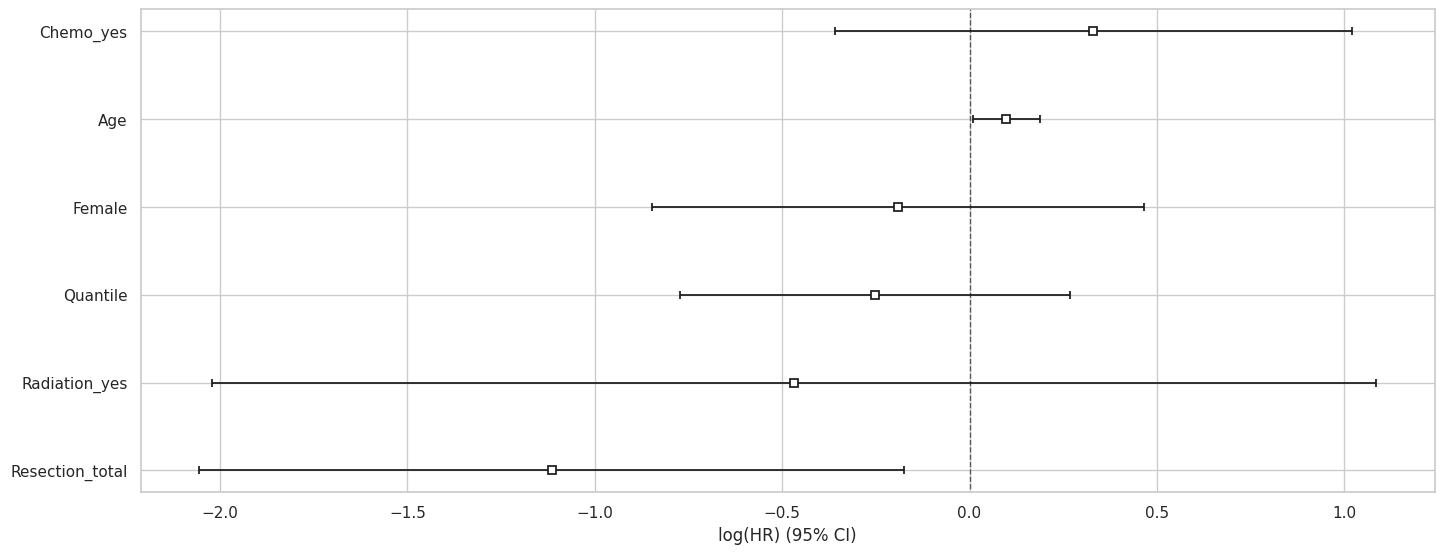

In [608]:
cph.plot()

In [601]:
# simpsons effect?

first_q = round(df_norm['TMT PRED AVG'].quantile([.25])[0.25],2)
mean_q = round(df_norm['TMT PRED AVG'].quantile([.5])[0.5],2)
third_q = round(df_norm['TMT PRED AVG'].quantile([.75])[0.75],2)


#min_q = round(df_survival['TMT PRED AVG'].quantile([.25])[0.25],2)
#max_q = round(df_survival['TMT PRED AVG'].quantile([.75])[0.75],2)

print("NORM", first_q, third_q)
print("Cancer", min_q,max_q)
cph.plot_partial_effects_on_outcome(covariates='TMT PRED AVG', values=[first_q, third_q], cmap='coolwarm')

NORM 9.44 12.42
Cancer 8.35 12.41


KeyError: 'covariate `TMT PRED AVG` is not present in the original dataset'

<AxesSubplot: >

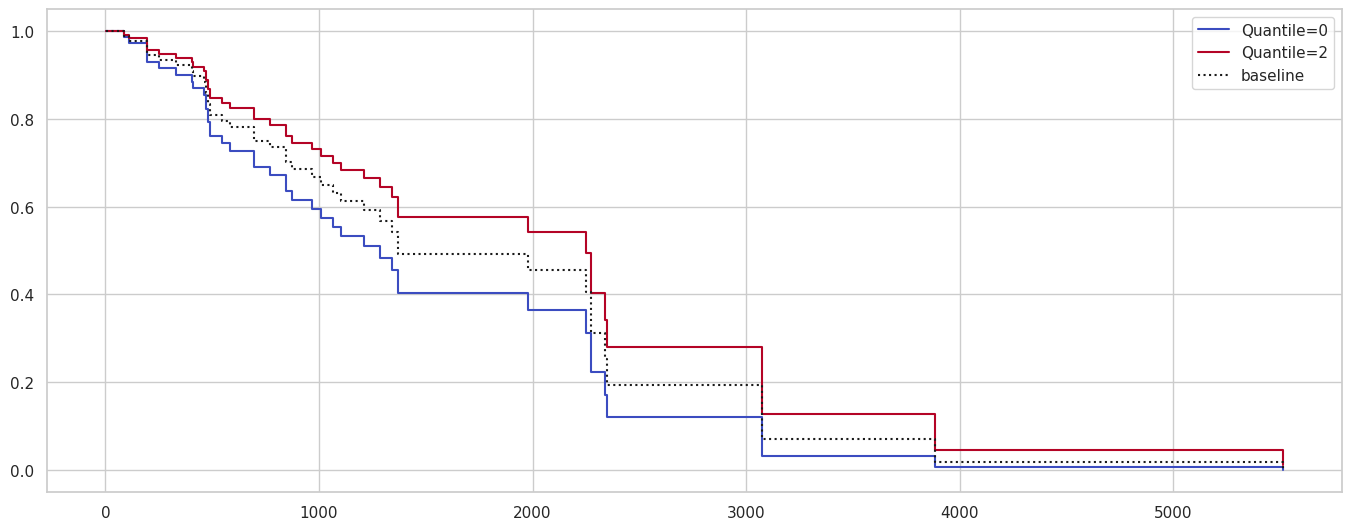

In [618]:
# make it age-specific   
cph.plot_partial_effects_on_outcome(covariates=['Quantile'], values=[0,2], cmap='coolwarm')

<AxesSubplot: >

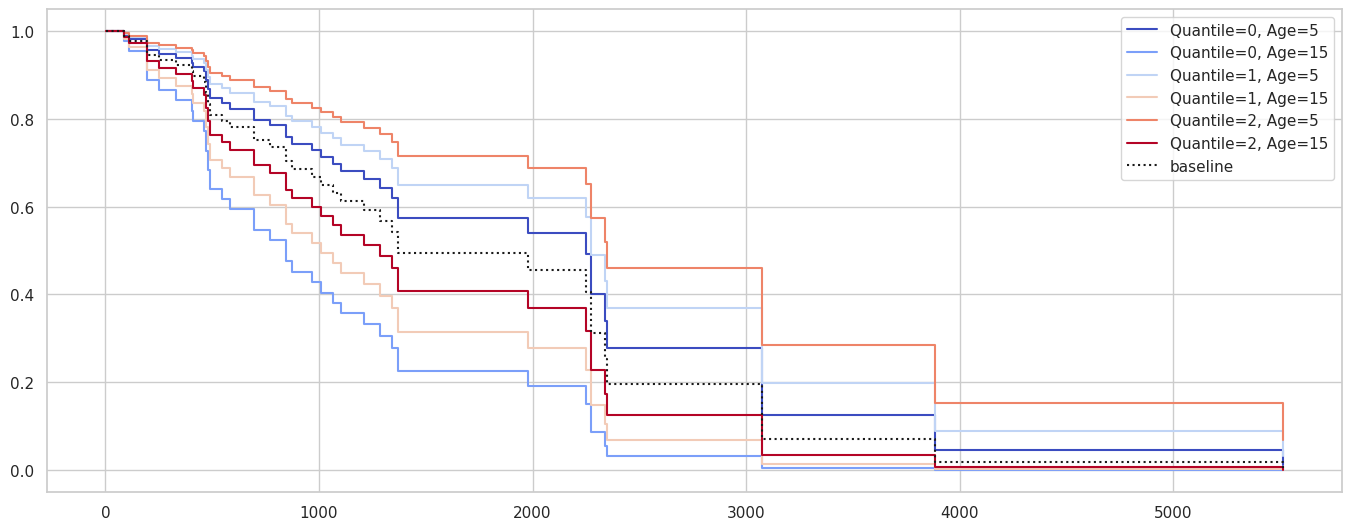

In [617]:
# make it age-specific   
cph.plot_partial_effects_on_outcome(covariates=['Quantile',"Age"], values=[[0,5],[0,15],
                                                                           [1,5],[1,15], 
                                                                           [2,5],[2,15]], cmap='coolwarm')


<AxesSubplot: >

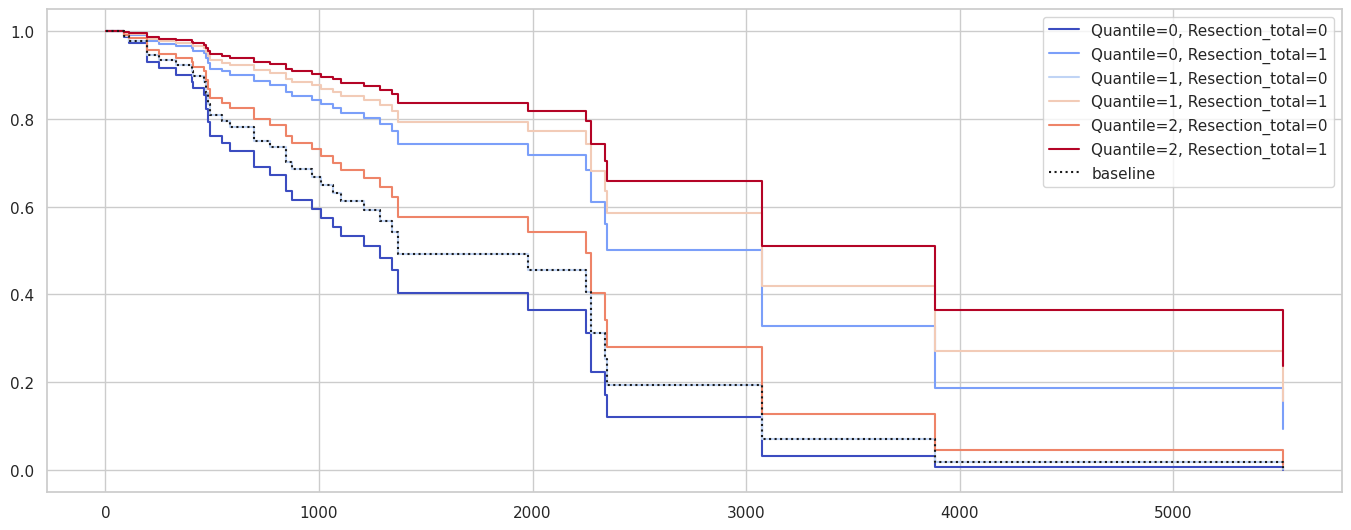

In [616]:
# make it age-specific   
cph.plot_partial_effects_on_outcome(covariates=['Quantile',"Resection_total"], values=[[0,0],[0,1],
                                                                               [1,0],[1,1],
                                                                                 [2,0],[2,1]], cmap='coolwarm')


<AxesSubplot: >

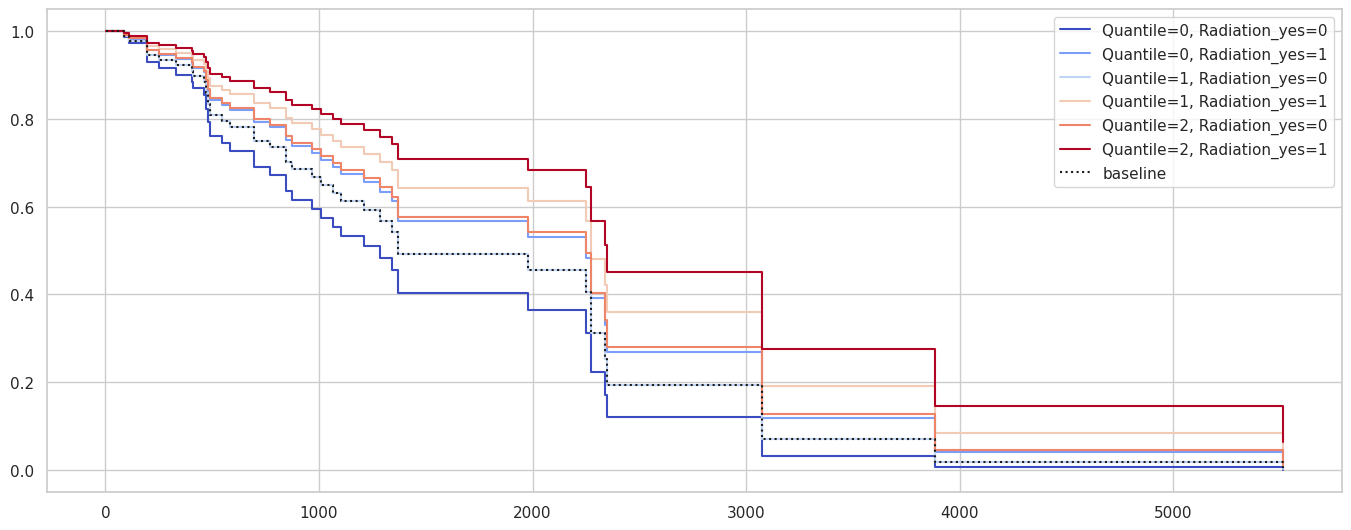

In [615]:
# make it age-specific   
cph.plot_partial_effects_on_outcome(covariates=['Quantile',"Radiation_yes"], values=[[0,0],[0,1],
                                                                                   [1,0],[1,1],
                                                                                 [2,0],[2,1]], cmap='coolwarm')


<AxesSubplot: >

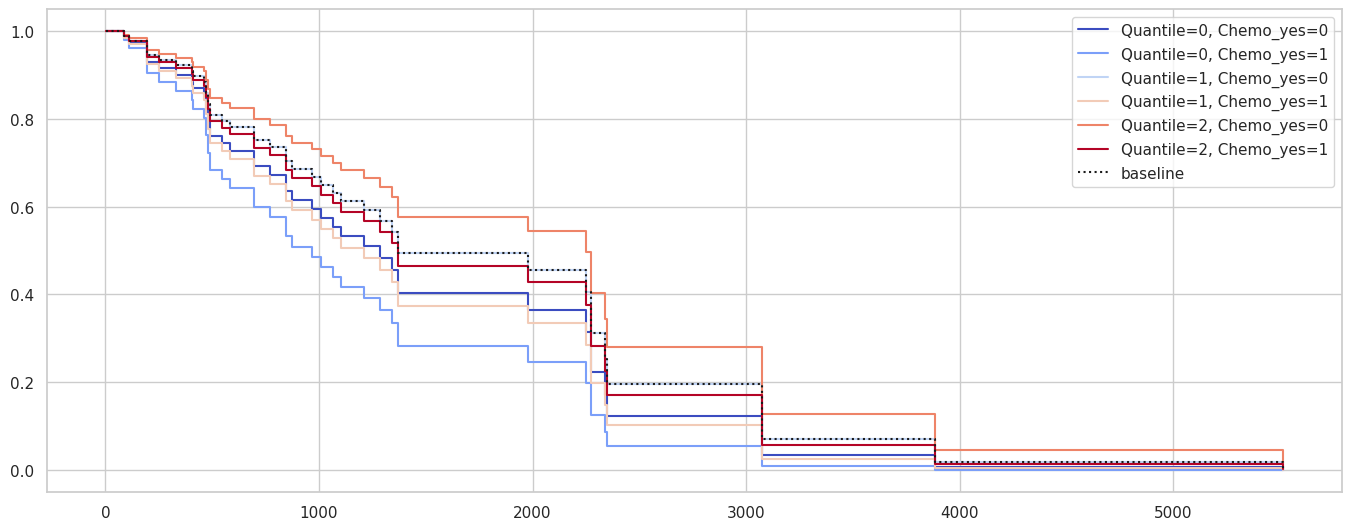

In [620]:
# make it age-specific   
cph.plot_partial_effects_on_outcome(covariates=['Quantile',"Chemo_yes"], values=[[0,0],[0,1],
                                                                            [1,0],[1,1],
                                                                            [2,0],[2,1]], cmap='coolwarm')


In [621]:
print(cph.concordance_index_)

0.7021510096575944


In [623]:
from lifelines.utils import k_fold_cross_validation
cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, df_surv, duration_col='Duration', event_col='Event', k=5)
print(scores)

scores = k_fold_cross_validation(cph, df_surv, duration_col='Duration', event_col='Event', k=5, scoring_method="concordance_index")
print(scores)

[-0.8026389635117316, -0.8104317240754673, -0.8218343811886919, -0.7496615069182817, -0.8174454962896569]
[0.6923076923076923, 0.7866666666666666, 0.7567567567567568, 0.6027397260273972, 0.53125]


In [624]:
np.array(scores).mean()

0.6739441683517026

In [626]:
from lifelines.statistics import multivariate_logrank_test

results = multivariate_logrank_test(df_surv['Duration'], df_surv['Quantile'], df_surv['Event'], weightings='peto')
results.print_summary()

<lifelines.StatisticalResult: multivariate_Peto_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_Peto_test

---
 test_statistic    p  -log2(p)
           0.24 0.89      0.17

In [627]:
from lifelines.statistics import multivariate_logrank_test

results = multivariate_logrank_test(df_surv['Duration'], df_surv['Resection_total'], df_surv['Event'], weightings='peto')
results.print_summary()

<lifelines.StatisticalResult: multivariate_Peto_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_Peto_test

---
 test_statistic      p  -log2(p)
          10.25 <0.005      9.51

<AxesSubplot: xlabel='timeline'>

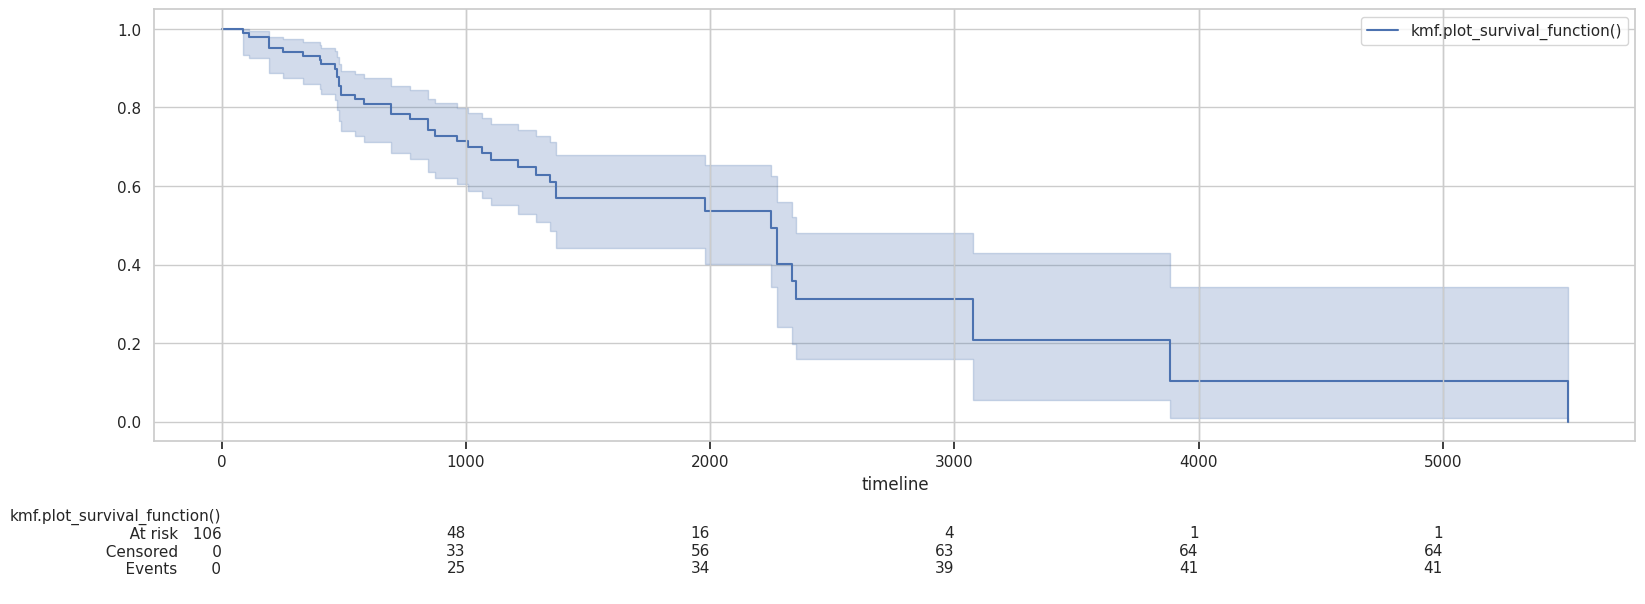

In [630]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(df_surv['Duration'], df_surv['Event'], label="kmf.plot_survival_function()")
kmf.plot_survival_function(at_risk_counts=True)


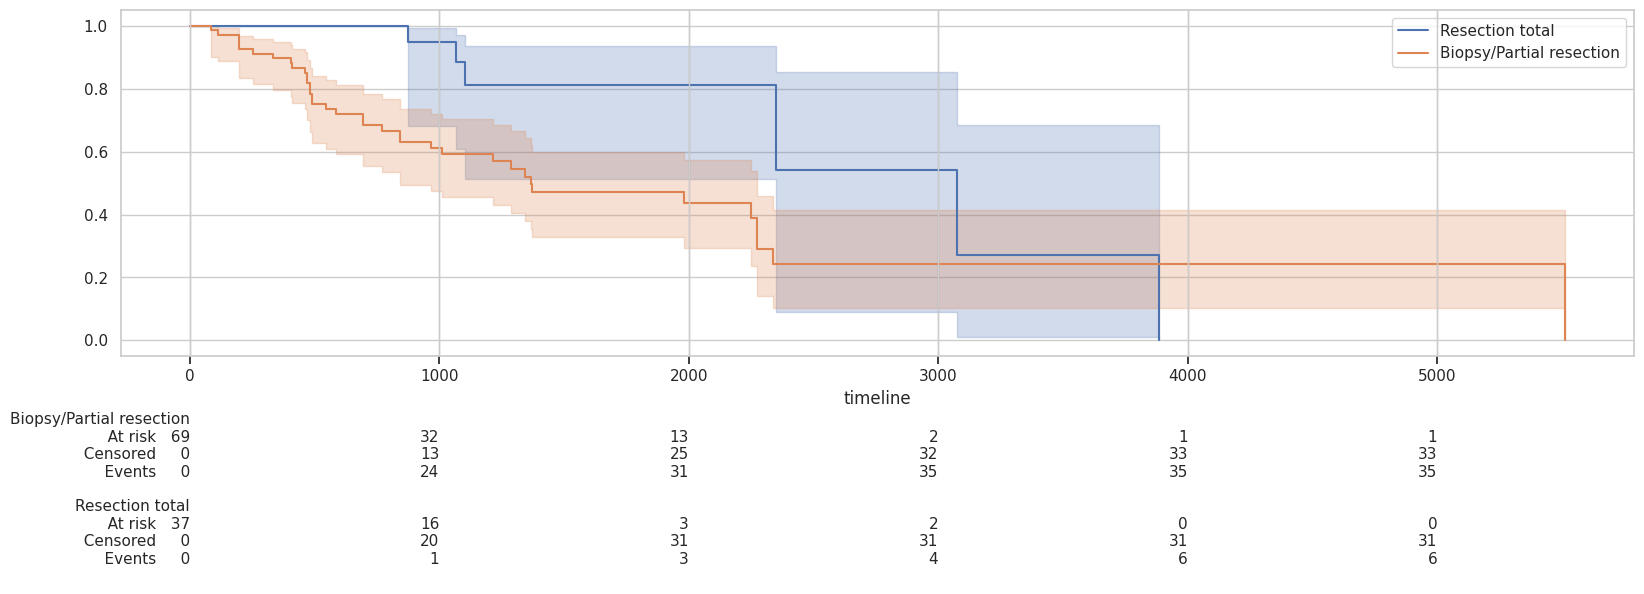

In [635]:
from lifelines import KaplanMeierFitter
from lifelines.datasets import load_waltons

ix = df_surv['Resection_total'] == 1

ax = plt.subplot(111)

kmf_control = KaplanMeierFitter()

ax = kmf_control.fit(df_surv.loc[ix]['Duration'], df_surv.loc[ix]['Event'], label='Resection total').plot_survival_function(ax=ax)

kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(df_surv.loc[~ix]['Duration'], df_surv.loc[~ix]['Event'], label='Biopsy/Partial resection').plot_survival_function(ax=ax)


from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_exp, kmf_control, ax=ax)
plt.tight_layout()

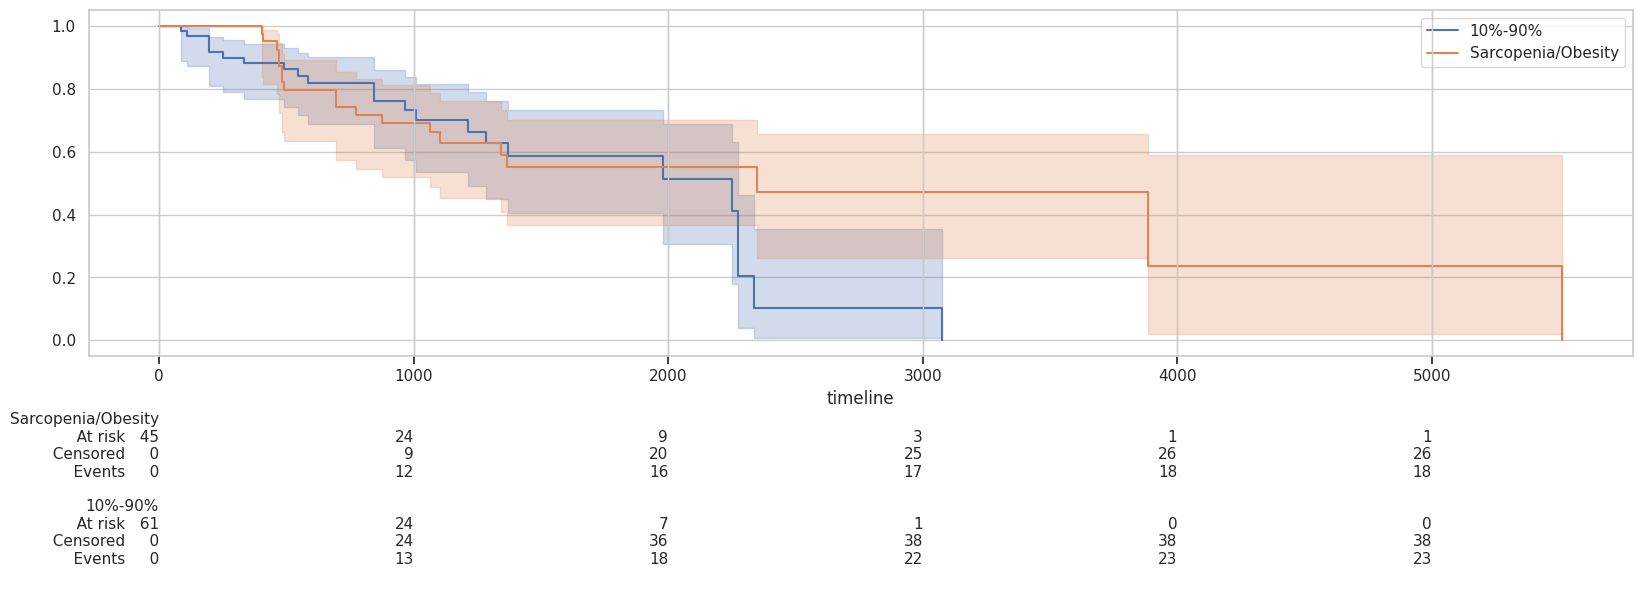

In [634]:
from lifelines import KaplanMeierFitter
from lifelines.datasets import load_waltons

ix = df_surv['Quantile'] == 1

ax = plt.subplot(111)

kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(df_surv.loc[ix]['Duration'], df_surv.loc[ix]['Event'], label='10%-90%').plot_survival_function(ax=ax)

kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(df_surv.loc[~ix]['Duration'], df_surv.loc[~ix]['Event'], label='Sarcopenia/Obesity').plot_survival_function(ax=ax)


from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_exp, kmf_control, ax=ax)
plt.tight_layout()